# import library

In [1]:
import yfinance as yf
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import ta
#import talib
from fracdiff.sklearn import Fracdiff, FracdiffStat
import numpy as np
from advanced_ta import LorentzianClassification
import pandas_ta
import random
import torch


# Set seed

In [2]:


seed = 41
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)


# Download Input

In [3]:
ticker = 'IBM'
aapl = yf.download(ticker, start='2016-01-01', end='2024-01-01')
sp500 = yf.download('^GSPC', start='2016-01-01', end='2024-01-01')
# Align AAPL data with S&P 500 data
aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')
aapl['SP500_diff'] = aapl['SP500'].diff()

c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_144\3027763660.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')


In [4]:
fng_data = pd.read_csv('all_fng_csv.csv',index_col='Date', parse_dates=True)

# Data Preprocessing

### add technical indicators

In [6]:
aapl = add_all_ta_features(
    aapl, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


c:\Conda\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [7]:
aapl['diff'] = aapl['Close'].diff()
aapl['pct_change'] = aapl['Close'].pct_change()

In [8]:
aapl['Supertrend7_3'] = pandas_ta.supertrend(aapl['High'], aapl['Low'], aapl['Close'], length=7, multiplier=3)['SUPERT_7_3.0']
aapl['Supertrend10_3'] = pandas_ta.supertrend(aapl['High'], aapl['Low'], aapl['Close'], length=10, multiplier=3)['SUPERT_10_3.0']

aapl['trend_sma_fast-close'] = aapl['trend_sma_fast'] - aapl['Close']
aapl['trend_sma_slow-close'] = aapl['trend_sma_slow'] - aapl['Close']
aapl['trend_ema_fast-close'] = aapl['trend_ema_fast'] - aapl['Close']
aapl['trend_ema_slow-close'] = aapl['trend_ema_slow'] - aapl['Close']
aapl['volatility_bbm-close'] = aapl['volatility_bbm'] - aapl['Close']
aapl['volatility_bbh-close'] = aapl['volatility_bbh'] - aapl['Close']
aapl['volatility_bbl-close'] = aapl['volatility_bbl'] - aapl['Close']
aapl['Supertrend7_3-close'] = aapl['Supertrend7_3'] - aapl['Close']
aapl['Supertrend10_3-close'] = aapl['Supertrend10_3'] - aapl['Close']

stock = yf.download(ticker, period="12y", interval="1d")
#stock = aapl
stock['open'] = stock['Open']
stock['high'] = stock['High']
stock['low'] = stock['Low']
stock['close'] = stock['Close']
stock['volume'] = stock['Volume']
# df here is the dataframe containing stock data as [['open', 'high', 'low', 'close', 'volume']]. Notice that the column names are in lower case.
lc = LorentzianClassification(
    stock,
    features=[
        LorentzianClassification.Feature("RSI", 21, 2),  # f1
        LorentzianClassification.Feature("WT", 10, 11),  # f2
        LorentzianClassification.Feature("CCI", 20, 2),  # f3
        LorentzianClassification.Feature("ADX", 20, 2),  # f4
        LorentzianClassification.Feature("RSI", 9, 2),   # f5
        
        #MFI(stock['high'], stock['low'], stock['close'], stock['volume'], 14) #f6
    ],
    settings=LorentzianClassification.Settings(
        source=stock['close'],
        neighborsCount=2,
        maxBarsBack=20000,
        useDynamicExits=False
    )
)
#lc.data['prediction']=lc.data['prediction'].shift(-1)
aapl = aapl.merge(lc.data[['prediction']],left_index=True, right_index=True, how='left')
aapl = aapl.merge(fng_data,left_index=True, right_index=True, how='left')

C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_144\1473325851.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aapl['volatility_bbl-close'] = aapl['volatility_bbl'] - aapl['Close']
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_144\1473325851.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aapl['Supertrend7_3-close'] = aapl['Supertrend7_3'] - aapl['Close']
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_144\1473325851.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [9]:
aapl.dropna(inplace=True)

### Fractional Differenciation

In [10]:
fd = FracdiffStat()
for indicator in aapl.columns:
    prob = adfuller(aapl[indicator])[1]
    print(indicator, prob)
    if prob > 0.01 and indicator != "Tomorrow" and indicator != "Target":
        fdindicator = indicator + '_fdiff'
        #pctindicator = indicator + '_pctdiff'
        aapl[fdindicator] = fd.fit_transform(aapl[[indicator]].values)
        #aapl[pctindicator] = aapl[indicator].pct_change()
        aapl.drop(columns=indicator, inplace=True)
aapl = aapl.iloc[6:]
labels = (aapl['diff']>0).tolist()
close_pct_change = aapl['pct_change'].tolist()

Open 0.03269034960121114
High 0.028324334416600115
Low 0.025097826768857266
Close 0.013727402187834881
Adj Close 0.2763762963817091
Volume 4.102950987893394e-21
SP500 0.8092009423643507
SP500_diff 6.51010360809308e-26
volume_adi 0.3577536458749374
volume_obv 0.04665486452656679
volume_cmf 5.025921149866624e-07
volume_fi 4.908637072383744e-23
volume_em 1.0523207007820572e-26
volume_sma_em 2.0248649008307997e-15
volume_vpt 0.6595099514521122
volume_vwap 0.07422283529205168
volume_mfi 8.028712383053522e-12
volume_nvi 0.9854726222934831
volatility_bbm 0.020619626999277618
volatility_bbh 0.002205895498351265
volatility_bbl 0.009095160255738005
volatility_bbw 3.8263793526765066e-08
volatility_bbp 1.2878261061861716e-22
volatility_bbhi 2.1086986908361757e-30
volatility_bbli 1.2763298658809072e-29
volatility_kcc 0.04773256593977911
volatility_kch 0.027378397909415264
volatility_kcl 0.05205475426686409
volatility_kcw 5.803435878253399e-06
volatility_kcp 4.5860587264479785e-26
volatility_kchi 5.

### Min Max Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(aapl)

# Create Sequence and Dataloader for K Fold LSTM

In [13]:
sequence_length = 20

# Function to create sequences
def create_sequences(data, labels, pct_change, all_date, seq_length):
    xs = []
    ys = []
    pct_list = []
    date_list = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = labels[i+seq_length]
        pct = pct_change[i+seq_length]
        date = all_date[i+seq_length]
        xs.append(x)
        ys.append(y)
        pct_list.append(pct)
        date_list.append(date)
    return np.array(xs), np.array(ys), np.array(pct_list), np.array(date_list)


X_all, y_all, pct_list, date_list = create_sequences(data_scaled, labels, close_pct_change, all_date, sequence_length)

In [14]:
from sklearn.model_selection import KFold

# Define the number of splits for K-Fold
n_splits = 10
validationLength = 100
# Create the KFold object with the specified number of splits
kf = KFold(n_splits=n_splits)

# Initialize lists to hold the fold data
X_train_folds = []
y_train_folds = []
X_val_folds = []
y_val_folds = []
pct_train_folds = []
pct_val_folds = []
date_val_fold = []
# Generate the indices for the K-Fold
kf_indices = kf.split(X_all[0:len(X_all) - validationLength])

# Loop through each fold
for train_index, val_index in kf_indices:
    # Generate the training and validation sets for X and y
    X_train, X_val = X_all[train_index], X_all[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    pct_train, pct_val = pct_list[train_index], pct_list[val_index]
    date_val = date_list[val_index]
    # Append the data for this fold to the lists
    X_train_folds.append(X_train)
    y_train_folds.append(y_train)
    X_val_folds.append(X_val)
    y_val_folds.append(y_val)
    pct_train_folds.append(pct_train)
    pct_val_folds.append(pct_val)
    date_val_fold.append(date_val)
# Now you have your folds in the _folds lists, and can train and validate your models on them.

In [15]:
for train_index, val_index in kf_indices:
    print(type(train_index))

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

In [17]:
def createDataLoader(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    # Create the dataset
    traindataset = StockDataset(X_train_tensor, y_train_tensor)

    # Create the DataLoader
    trainLoader = DataLoader(traindataset, batch_size=32, shuffle=False)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create the dataset
    valdataset = StockDataset(X_val_tensor, y_val_tensor)

    # Create the DataLoader
    valLoader = DataLoader(valdataset, batch_size=32, shuffle=False)

  
    return trainLoader, valLoader

# Defining Model

In [18]:
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers, dropout_prob = 0.5):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_units, num_layers,dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

num_features = X_train_folds[0].shape[-1]  # Number of features
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers



# Model Training and Evaluation

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Tuple
from sklearn.metrics import accuracy_score

# Assuming 'StockPredictor' is a class derived from nn.Module
# and 'trainLoader' is an instance of DataLoader

def train_model(
    model: nn.Module, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int) -> Tuple[nn.Module, list]:
    """
    Train the model and return the model with the minimum loss.

    Parameters:
    - model: The neural network model to train.
    - train_loader: DataLoader for the training data.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - num_epochs: Number of epochs to train.
    
    Returns:
    - min_loss_model: The model with the minimum loss achieved during training.
    - epoch_loss_history: List of loss values recorded at the end of each epoch.
    """
    min_loss = float('inf')
    minValLoss = float('inf')
    min_loss_model = StockPredictor(num_features, hidden_units, num_layers)  # Assumes these are attributes of your model
    minValLossModel = StockPredictor(num_features, hidden_units, num_layers)
    maxAccuracyModel = StockPredictor(num_features, hidden_units, num_layers)
    train_epoch_loss_history = []
    test_epoch_loss_history = []
    maxaccuracy = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            predictions = model(features).squeeze()
            loss = criterion(predictions, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_epoch_loss_history.append(loss.item())
        if loss.item() < min_loss:
            min_loss = loss.item()
            min_loss_model.load_state_dict(model.state_dict())  # Copy model weights
        
        model.eval()
        valPredictions = []
        actuals = []
        validation_loss = 0.0
        with torch.no_grad():  # No need to track the gradients
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                # Forward pass to get output/prediction
                outputs = model(features).squeeze()
                val_loss = criterion(outputs, labels)
                validation_loss += val_loss.item()
                
                # Since we're using sigmoid, we will round the outputs to get the binary class
                predicted_classes = torch.round(outputs)
                
                if predicted_classes.ndim == 0:
                    predicted_classes = predicted_classes.unsqueeze(0)

                # Store valPredictions and actual labels
                valPredictions.extend(predicted_classes.cpu().numpy())
                actuals.extend(labels.cpu().numpy())
        accuracy = accuracy_score(np.array(actuals), np.array(valPredictions))
        validation_loss /= len(val_loader)
        test_epoch_loss_history.append(validation_loss)
        if minValLoss >= validation_loss:
            minValLoss = validation_loss
            minValLossModel.load_state_dict(model.state_dict())
            maxaccuracy = accuracy
        """if maxaccuracy <= accuracy:
            maxAccuracyModel.load_state_dict(model.state_dict())"""
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}, accuracy: {accuracy:.4f} maxaccuracy: {maxaccuracy:.4f}  Validation Loss: {validation_loss:.4f}, Minimum Validation Loss: {minValLoss:.4f}')

    return model, train_epoch_loss_history,test_epoch_loss_history, maxaccuracy, minValLoss



# minLossModel, loss_history = train_model(model, trainLoader, criterion, optimizer, num_epochs)

In [20]:
import torch
from torch.utils.data import DataLoader

def evaluate_model(model: torch.nn.Module, test_loader: DataLoader) -> Tuple[list, list, list]:
    """
    Evaluate the model on the test set.

    Parameters:
    - model: The trained neural network model for evaluation.
    - test_loader: DataLoader for the test data.

    Returns:
    - probabilities: List of raw output probabilities from the model.
    - predictions: List of predicted classes based on the output probabilities.
    - actuals: List of actual labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    probabilities = []
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track the gradients
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass to get output/prediction
            outputs = model(features).squeeze()

            # Since we're using sigmoid, we will round the outputs to get the binary class
            predicted_classes = torch.round(outputs)
            
            # In case of single-element batches, add an extra dimension
            if predicted_classes.ndim == 0:
                predicted_classes = predicted_classes.unsqueeze(0)

            # Store predictions and actual labels
            probabilities.extend(outputs.cpu().numpy())
            predictions.extend(predicted_classes.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return probabilities, predictions, actuals

# Usage example
# Assuming 'minLossModel' is the trained model and 'testLoader' is defined elsewhere

# probabilities, predictions, actuals = evaluate_model(minLossModel, testLoader)

In [21]:

def cum_return(probabilities,  pct_change, dates, ticker):
    pct_change = np.array(pct_change)
    predictions_array = (np.array(probabilities) > 0.5).astype(int)
    
    # Calculate cumulative returns
    buy_and_hold = (pct_change + 1).cumprod()
    prediction = (predictions_array * pct_change + 1).cumprod()

    # Create the plot
    plt.figure(figsize=(10, 5))  # Adjust the size as needed
    plt.plot(dates, buy_and_hold, label='Buy & Hold')
    plt.plot(dates, prediction, label='Prediction')
    #plt.plot(dates, lc, label='lc')
    
    # Setting the x-axis as date
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.xlabel('Date')
    
    # Labels and legend
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='lower right')
    
    # Title
    plt.title(f"{ticker} Cumulative Return Comparison")
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Example usage of the function, assuming that 'aapl.index[20:-100]' is the desired date range
# Adjust 'probabilities', 'actuals', and 'aapl['pct_change']' to be aligned and have the same length

# Slice the dates
#dates = aapl.index[20:-100]

# Call the function with the aligned data


In [22]:
def downside_deviation(returns, threshold=0):
    # Calculate the difference between the returns and the threshold
    downside_diff = np.minimum(returns - threshold, 0)
    # Square the differences, sum them, divide by the number of observations,
    # and then take the square root
    return np.sqrt(np.mean(downside_diff ** 2))

def cum_return(probabilities, pct_change, dates, ticker, threshold=0):
    pct_change = np.array(pct_change)
    predictions_array = (np.array(probabilities) > 0.5).astype(int)
    
    # Calculate cumulative returns
    buy_and_hold = (pct_change + 1).cumprod()
    prediction = (predictions_array * pct_change + 1).cumprod()
    
    # Calculate downside deviations for buy and hold and prediction
    buy_and_hold_downside_dev = downside_deviation(pct_change, threshold)
    prediction_downside_dev = downside_deviation(predictions_array * pct_change, threshold)
    
    print(f"Buy & Hold Downside Deviation: {buy_and_hold_downside_dev}")
    print(f"Prediction Downside Deviation: {prediction_downside_dev}")

    # Create the plot for cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(dates, buy_and_hold, label='Buy & Hold')
    plt.plot(dates, prediction, label='Prediction')
    
    # Setting the x-axis as date
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    
    # Labels and legend
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='lower right')
    
    # Title
    plt.title(f"{ticker} Cumulative Return Comparison")
    
    # Show the plot for cumulative returns
    plt.tight_layout()
    plt.show()

    return prediction_downside_dev, prediction[-1]


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score

def evaluation(predictions, probabilities, actuals, verbose=1, threshold = 0.5):
    probabilities_array = np.array(probabilities)
    predictions_array = (probabilities_array >= threshold).astype(int)
    actuals_array = np.array(actuals)

    # Calculate various classification metrics
    accuracy = accuracy_score(actuals_array, predictions_array)
    precision = precision_score(actuals_array, predictions_array)
    recall = recall_score(actuals_array, predictions_array)
    f1 = f1_score(actuals_array, predictions_array)
    conf_matrix = confusion_matrix(actuals_array, predictions_array)
    auc_score = roc_auc_score(actuals_array, probabilities_array)

    # Print out the metrics
    if verbose:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'AUC Score: {auc_score:.4f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

round 1


Epoch [10/300], Loss: 0.6735, minimum Loss: 0.6734, accuracy: 0.5585 maxaccuracy: 0.5585  Validation Loss: 0.6893, Minimum Validation Loss: 0.6893
Epoch [20/300], Loss: 0.6708, minimum Loss: 0.6708, accuracy: 0.5106 maxaccuracy: 0.5585  Validation Loss: 0.6902, Minimum Validation Loss: 0.6893
Epoch [30/300], Loss: 0.6658, minimum Loss: 0.6653, accuracy: 0.5213 maxaccuracy: 0.5585  Validation Loss: 0.6913, Minimum Validation Loss: 0.6893
Epoch [40/300], Loss: 0.6570, minimum Loss: 0.6570, accuracy: 0.5532 maxaccuracy: 0.5585  Validation Loss: 0.6917, Minimum Validation Loss: 0.6893
Epoch [50/300], Loss: 0.6378, minimum Loss: 0.6378, accuracy: 0.5160 maxaccuracy: 0.5585  Validation Loss: 0.6922, Minimum Validation Loss: 0.6893
Epoch [60/300], Loss: 0.6097, minimum Loss: 0.6097, accuracy: 0.5372 maxaccuracy: 0.5585  Validation Loss: 0.6942, Minimum Validation Loss: 0.6893
Epoch [70/300], Loss: 0.5955, minimum Loss: 0.5916, accuracy: 0.5266 maxaccuracy: 0.5585  Validation Loss: 0.6996, Min

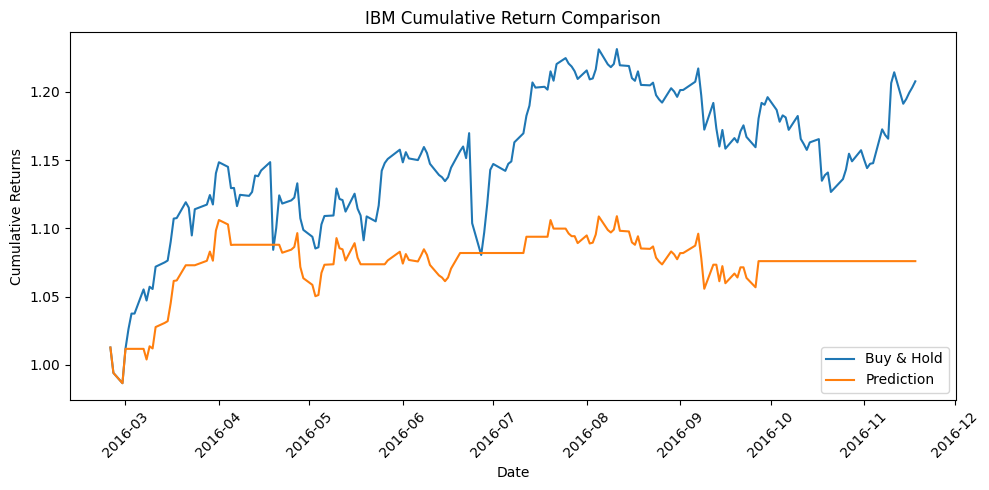

threshold = 0.5
Accuracy: 0.4521
Precision: 0.5098
Recall: 0.4952
F1 Score: 0.5024
AUC Score: 0.4722
Confusion Matrix:
[[33 50]
 [53 52]]

threshold = 0.55
Accuracy: 0.4415
Precision: 0.5000
Recall: 0.4381
F1 Score: 0.4670
AUC Score: 0.4722
Confusion Matrix:
[[37 46]
 [59 46]]
round 2
Epoch [10/300], Loss: 0.6697, minimum Loss: 0.6695, accuracy: 0.4787 maxaccuracy: 0.4787  Validation Loss: 0.6963, Minimum Validation Loss: 0.6951
Epoch [20/300], Loss: 0.6693, minimum Loss: 0.6686, accuracy: 0.4628 maxaccuracy: 0.4628  Validation Loss: 0.6951, Minimum Validation Loss: 0.6951
Epoch [30/300], Loss: 0.6673, minimum Loss: 0.6673, accuracy: 0.5160 maxaccuracy: 0.4521  Validation Loss: 0.6967, Minimum Validation Loss: 0.6950
Epoch [40/300], Loss: 0.6600, minimum Loss: 0.6600, accuracy: 0.5000 maxaccuracy: 0.4521  Validation Loss: 0.7022, Minimum Validation Loss: 0.6950
Epoch [50/300], Loss: 0.6429, minimum Loss: 0.6429, accuracy: 0.4947 maxaccuracy: 0.4521  Validation Loss: 0.7131, Minimum Val

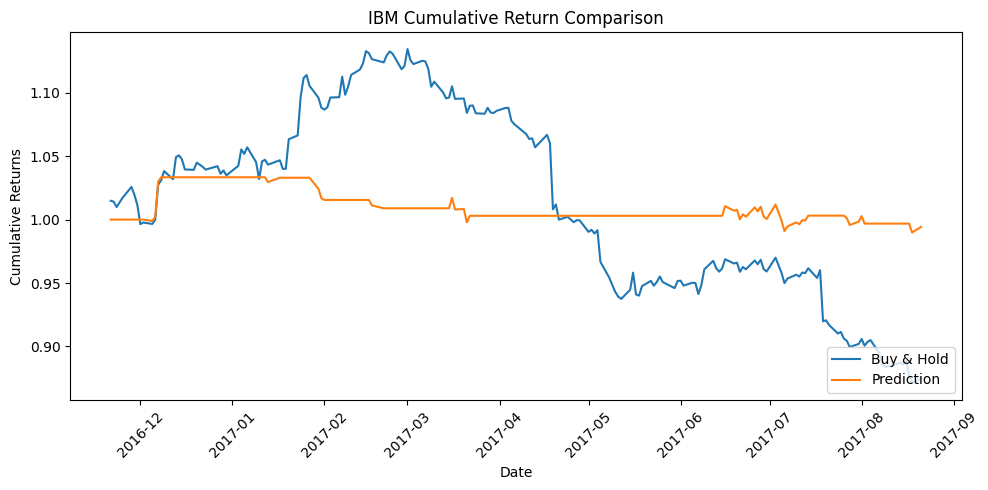

threshold = 0.5
Accuracy: 0.5053
Precision: 0.4651
Recall: 0.2222
F1 Score: 0.3008
AUC Score: 0.4834
Confusion Matrix:
[[75 23]
 [70 20]]

threshold = 0.55
Accuracy: 0.5106
Precision: 0.4688
Recall: 0.1667
F1 Score: 0.2459
AUC Score: 0.4834
Confusion Matrix:
[[81 17]
 [75 15]]
round 3
Epoch [10/300], Loss: 0.6732, minimum Loss: 0.6730, accuracy: 0.5213 maxaccuracy: 0.5213  Validation Loss: 0.6923, Minimum Validation Loss: 0.6923
Epoch [20/300], Loss: 0.6717, minimum Loss: 0.6717, accuracy: 0.5319 maxaccuracy: 0.5213  Validation Loss: 0.6925, Minimum Validation Loss: 0.6923
Epoch [30/300], Loss: 0.6717, minimum Loss: 0.6709, accuracy: 0.4894 maxaccuracy: 0.5213  Validation Loss: 0.6928, Minimum Validation Loss: 0.6923
Epoch [40/300], Loss: 0.6695, minimum Loss: 0.6687, accuracy: 0.5053 maxaccuracy: 0.5213  Validation Loss: 0.6928, Minimum Validation Loss: 0.6923
Epoch [50/300], Loss: 0.6672, minimum Loss: 0.6672, accuracy: 0.5000 maxaccuracy: 0.5213  Validation Loss: 0.6927, Minimum Val

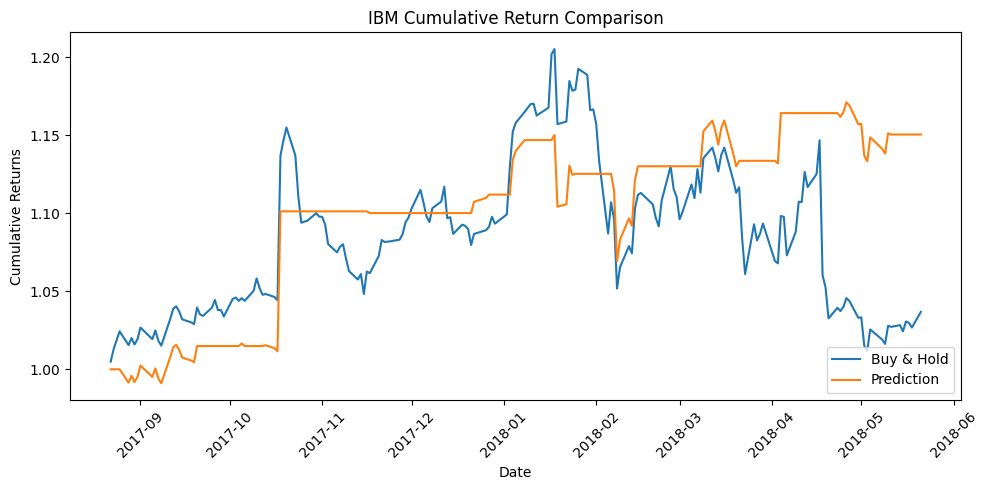

threshold = 0.5
Accuracy: 0.5000
Precision: 0.5294
Recall: 0.3673
F1 Score: 0.4337
AUC Score: 0.4975
Confusion Matrix:
[[58 32]
 [62 36]]

threshold = 0.55
Accuracy: 0.4734
Precision: 0.4906
Recall: 0.2653
F1 Score: 0.3444
AUC Score: 0.4975
Confusion Matrix:
[[63 27]
 [72 26]]
round 4
Epoch [10/300], Loss: 0.6716, minimum Loss: 0.6716, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6902, Minimum Validation Loss: 0.6902
Epoch [20/300], Loss: 0.6695, minimum Loss: 0.6695, accuracy: 0.5319 maxaccuracy: 0.5319  Validation Loss: 0.6888, Minimum Validation Loss: 0.6888
Epoch [30/300], Loss: 0.6652, minimum Loss: 0.6652, accuracy: 0.5532 maxaccuracy: 0.5532  Validation Loss: 0.6881, Minimum Validation Loss: 0.6881
Epoch [40/300], Loss: 0.6578, minimum Loss: 0.6578, accuracy: 0.5532 maxaccuracy: 0.5213  Validation Loss: 0.6884, Minimum Validation Loss: 0.6881
Epoch [50/300], Loss: 0.6455, minimum Loss: 0.6455, accuracy: 0.4840 maxaccuracy: 0.5213  Validation Loss: 0.6902, Minimum Val

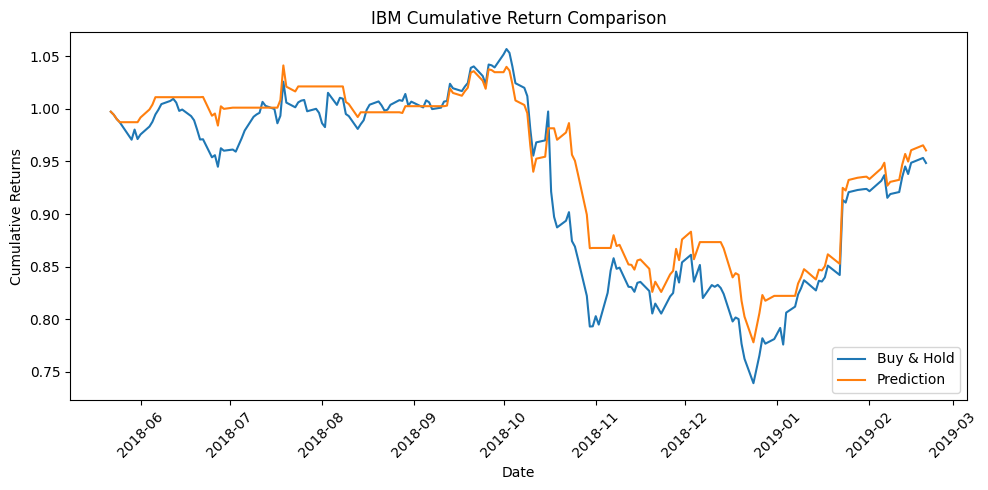

threshold = 0.5
Accuracy: 0.5000
Precision: 0.5250
Recall: 0.6300
F1 Score: 0.5727
AUC Score: 0.4951
Confusion Matrix:
[[31 57]
 [37 63]]

threshold = 0.55
Accuracy: 0.4947
Precision: 0.5269
Recall: 0.4900
F1 Score: 0.5078
AUC Score: 0.4951
Confusion Matrix:
[[44 44]
 [51 49]]
round 5
Epoch [10/300], Loss: 0.6745, minimum Loss: 0.6745, accuracy: 0.5585 maxaccuracy: 0.5585  Validation Loss: 0.6900, Minimum Validation Loss: 0.6898
Epoch [20/300], Loss: 0.6704, minimum Loss: 0.6704, accuracy: 0.5479 maxaccuracy: 0.5585  Validation Loss: 0.6906, Minimum Validation Loss: 0.6898
Epoch [30/300], Loss: 0.6643, minimum Loss: 0.6643, accuracy: 0.5319 maxaccuracy: 0.5585  Validation Loss: 0.6916, Minimum Validation Loss: 0.6898
Epoch [40/300], Loss: 0.6561, minimum Loss: 0.6561, accuracy: 0.4840 maxaccuracy: 0.5585  Validation Loss: 0.6937, Minimum Validation Loss: 0.6898
Epoch [50/300], Loss: 0.6432, minimum Loss: 0.6432, accuracy: 0.4894 maxaccuracy: 0.5585  Validation Loss: 0.6987, Minimum Val

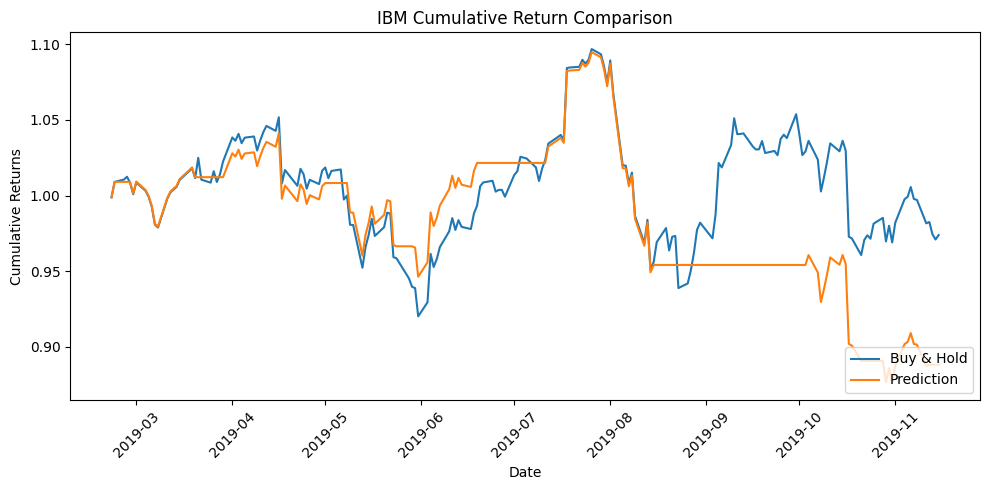

threshold = 0.5
Accuracy: 0.4734
Precision: 0.5263
Recall: 0.5714
F1 Score: 0.5479
AUC Score: 0.4383
Confusion Matrix:
[[29 54]
 [45 60]]

threshold = 0.55
Accuracy: 0.4681
Precision: 0.5238
Recall: 0.5238
F1 Score: 0.5238
AUC Score: 0.4383
Confusion Matrix:
[[33 50]
 [50 55]]
round 6
Epoch [10/300], Loss: 0.6704, minimum Loss: 0.6699, accuracy: 0.5053 maxaccuracy: 0.5053  Validation Loss: 0.6931, Minimum Validation Loss: 0.6930
Epoch [20/300], Loss: 0.6671, minimum Loss: 0.6671, accuracy: 0.5053 maxaccuracy: 0.5053  Validation Loss: 0.6922, Minimum Validation Loss: 0.6922
Epoch [30/300], Loss: 0.6638, minimum Loss: 0.6638, accuracy: 0.5372 maxaccuracy: 0.5372  Validation Loss: 0.6919, Minimum Validation Loss: 0.6919
Epoch [40/300], Loss: 0.6584, minimum Loss: 0.6584, accuracy: 0.5213 maxaccuracy: 0.5213  Validation Loss: 0.6918, Minimum Validation Loss: 0.6917
Epoch [50/300], Loss: 0.6514, minimum Loss: 0.6514, accuracy: 0.5000 maxaccuracy: 0.5053  Validation Loss: 0.6919, Minimum Val

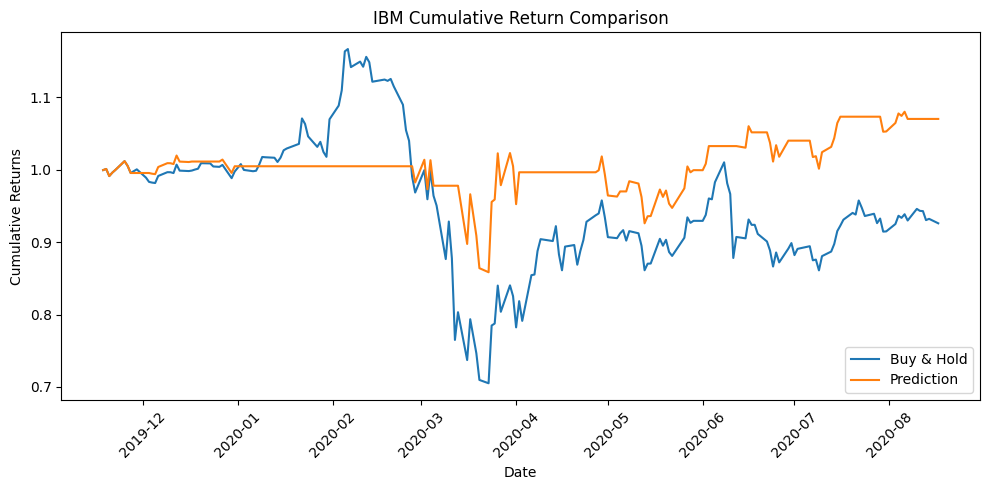

threshold = 0.5
Accuracy: 0.5000
Precision: 0.5057
Recall: 0.4632
F1 Score: 0.4835
AUC Score: 0.5338
Confusion Matrix:
[[50 43]
 [51 44]]

threshold = 0.55
Accuracy: 0.5106
Precision: 0.5238
Recall: 0.3474
F1 Score: 0.4177
AUC Score: 0.5338
Confusion Matrix:
[[63 30]
 [62 33]]
round 7
Epoch [10/300], Loss: 0.6703, minimum Loss: 0.6702, accuracy: 0.5187 maxaccuracy: 0.5187  Validation Loss: 0.6939, Minimum Validation Loss: 0.6927
Epoch [20/300], Loss: 0.6668, minimum Loss: 0.6668, accuracy: 0.5187 maxaccuracy: 0.5187  Validation Loss: 0.6964, Minimum Validation Loss: 0.6927
Epoch [30/300], Loss: 0.6636, minimum Loss: 0.6636, accuracy: 0.5080 maxaccuracy: 0.5187  Validation Loss: 0.6979, Minimum Validation Loss: 0.6927
Epoch [40/300], Loss: 0.6592, minimum Loss: 0.6592, accuracy: 0.5134 maxaccuracy: 0.5187  Validation Loss: 0.6988, Minimum Validation Loss: 0.6927
Epoch [50/300], Loss: 0.6555, minimum Loss: 0.6547, accuracy: 0.5134 maxaccuracy: 0.5187  Validation Loss: 0.6992, Minimum Val

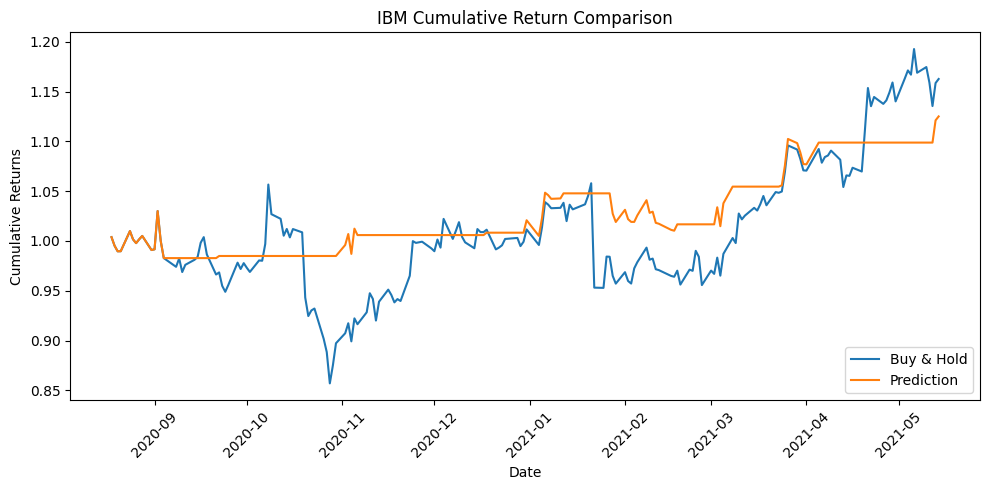

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5439
Recall: 0.3196
F1 Score: 0.4026
AUC Score: 0.5037
Confusion Matrix:
[[64 26]
 [66 31]]

threshold = 0.55
Accuracy: 0.5027
Precision: 0.5417
Recall: 0.2680
F1 Score: 0.3586
AUC Score: 0.5037
Confusion Matrix:
[[68 22]
 [71 26]]
round 8
Epoch [10/300], Loss: 0.6697, minimum Loss: 0.6697, accuracy: 0.5027 maxaccuracy: 0.5027  Validation Loss: 0.6928, Minimum Validation Loss: 0.6928
Epoch [20/300], Loss: 0.6676, minimum Loss: 0.6676, accuracy: 0.5027 maxaccuracy: 0.5027  Validation Loss: 0.6916, Minimum Validation Loss: 0.6916
Epoch [30/300], Loss: 0.6632, minimum Loss: 0.6628, accuracy: 0.5294 maxaccuracy: 0.5294  Validation Loss: 0.6910, Minimum Validation Loss: 0.6910
Epoch [40/300], Loss: 0.6520, minimum Loss: 0.6520, accuracy: 0.4973 maxaccuracy: 0.4973  Validation Loss: 0.6903, Minimum Validation Loss: 0.6903
Epoch [50/300], Loss: 0.6184, minimum Loss: 0.6184, accuracy: 0.4920 maxaccuracy: 0.5080  Validation Loss: 0.6902, Minimum Val

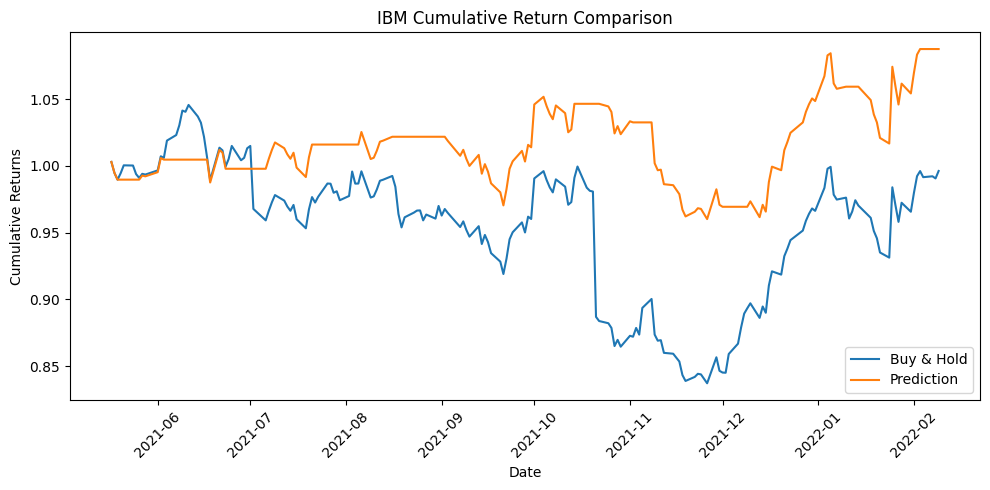

threshold = 0.5
Accuracy: 0.4759
Precision: 0.4828
Recall: 0.5957
F1 Score: 0.5333
AUC Score: 0.4900
Confusion Matrix:
[[33 60]
 [38 56]]

threshold = 0.55
Accuracy: 0.4973
Precision: 0.5000
Recall: 0.5319
F1 Score: 0.5155
AUC Score: 0.4900
Confusion Matrix:
[[43 50]
 [44 50]]
round 9
Epoch [10/300], Loss: 0.6695, minimum Loss: 0.6688, accuracy: 0.5134 maxaccuracy: 0.5134  Validation Loss: 0.6938, Minimum Validation Loss: 0.6931
Epoch [20/300], Loss: 0.6682, minimum Loss: 0.6668, accuracy: 0.5134 maxaccuracy: 0.5134  Validation Loss: 0.6939, Minimum Validation Loss: 0.6931
Epoch [30/300], Loss: 0.6679, minimum Loss: 0.6667, accuracy: 0.5134 maxaccuracy: 0.5134  Validation Loss: 0.6938, Minimum Validation Loss: 0.6931
Epoch [40/300], Loss: 0.6649, minimum Loss: 0.6632, accuracy: 0.4973 maxaccuracy: 0.5134  Validation Loss: 0.6941, Minimum Validation Loss: 0.6931
Epoch [50/300], Loss: 0.6538, minimum Loss: 0.6538, accuracy: 0.5134 maxaccuracy: 0.5134  Validation Loss: 0.6960, Minimum Val

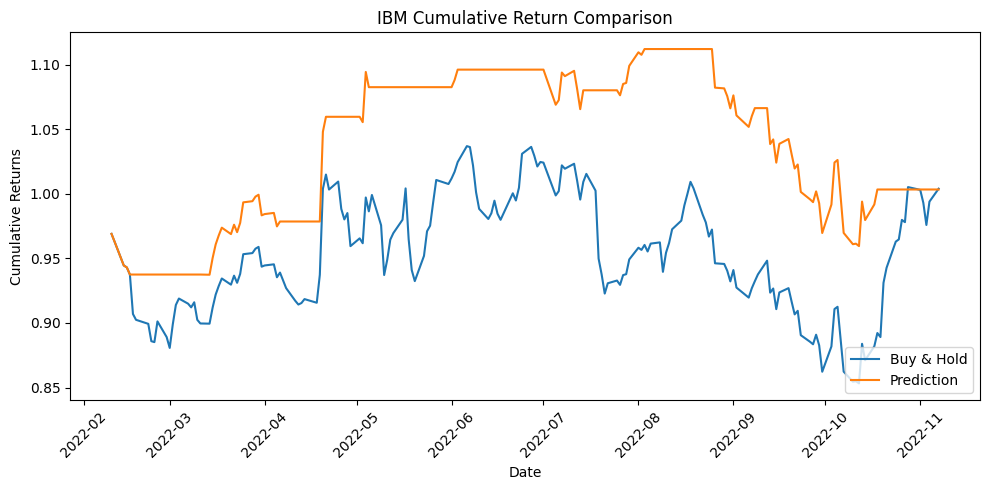

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5250
Recall: 0.4375
F1 Score: 0.4773
AUC Score: 0.5095
Confusion Matrix:
[[53 38]
 [54 42]]

threshold = 0.55
Accuracy: 0.4866
Precision: 0.5000
Recall: 0.3438
F1 Score: 0.4074
AUC Score: 0.5095
Confusion Matrix:
[[58 33]
 [63 33]]
round 10
Epoch [10/300], Loss: 0.6882, minimum Loss: 0.6878, accuracy: 0.5508 maxaccuracy: 0.5508  Validation Loss: 0.6890, Minimum Validation Loss: 0.6890
Epoch [20/300], Loss: 0.6858, minimum Loss: 0.6853, accuracy: 0.5508 maxaccuracy: 0.5455  Validation Loss: 0.6889, Minimum Validation Loss: 0.6888
Epoch [30/300], Loss: 0.6840, minimum Loss: 0.6840, accuracy: 0.5294 maxaccuracy: 0.5455  Validation Loss: 0.6891, Minimum Validation Loss: 0.6888
Epoch [40/300], Loss: 0.6836, minimum Loss: 0.6824, accuracy: 0.5080 maxaccuracy: 0.5455  Validation Loss: 0.6898, Minimum Validation Loss: 0.6888
Epoch [50/300], Loss: 0.6823, minimum Loss: 0.6823, accuracy: 0.4973 maxaccuracy: 0.5455  Validation Loss: 0.6912, Minimum Va

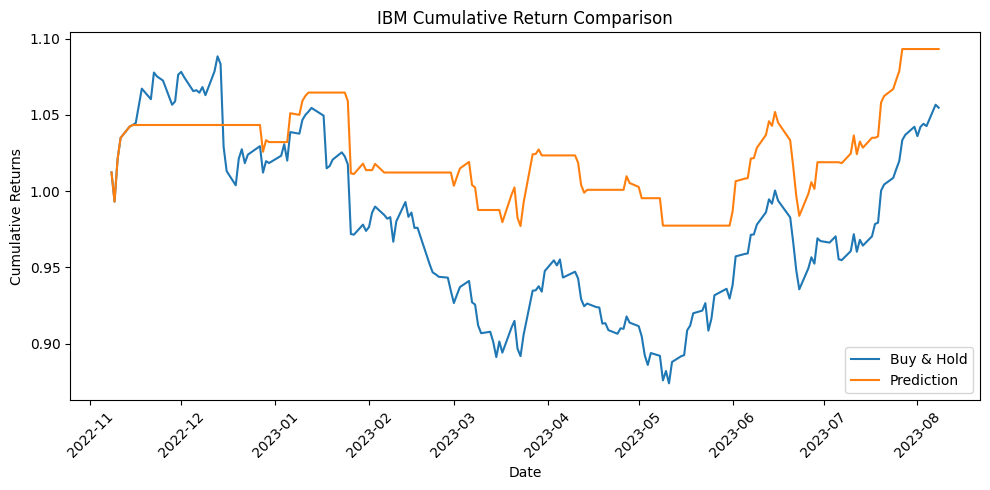

threshold = 0.5
Accuracy: 0.5187
Precision: 0.5802
Recall: 0.4563
F1 Score: 0.5109
AUC Score: 0.5563
Confusion Matrix:
[[50 34]
 [56 47]]

threshold = 0.55
Accuracy: 0.5348
Precision: 0.6212
Recall: 0.3981
F1 Score: 0.4852
AUC Score: 0.5563
Confusion Matrix:
[[59 25]
 [62 41]]


In [24]:
from tqdm import tqdm

# Define the model
num_features = X_train_folds[0].shape[-1]  # Number of features
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers

num_epochs = 300
probabilities, predictions, actuals, train_loss_history, test_loss_history , all_pct_change, downside_deviation_list, cumulative_return_list= [], [] ,[], [], [],[],[],[]
for i in range(len(X_train_folds)):
    print(f'round {i+1}')
    trainLoader, valLoader= createDataLoader(X_train_folds[i],y_train_folds[i],X_val_folds[i],y_val_folds[i])
    accuracy, validationLoss,train_loss_history_tmp, test_loss_history_tmp = 0,float('inf'), [],[]
    
    model = StockPredictor(num_features, hidden_units, num_layers,dropout_prob=0.1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)
    model, train_loss_history_tmp, test_loss_history_tmp,accuracy, validationLoss = train_model(model, trainLoader,valLoader, criterion, optimizer, num_epochs)

    probabilities_tmp, predictions_tmp, actuals_tmp = evaluate_model(model, valLoader)
    dd, cr = cum_return(probabilities_tmp, pct_val_folds[i], date_val_fold[i],ticker)
    probabilities.extend(probabilities_tmp)
    predictions.extend(predictions_tmp)
    actuals.extend(actuals_tmp)
    all_pct_change.extend(pct_val_folds[i])
    train_loss_history.append(train_loss_history_tmp)
    test_loss_history.append(test_loss_history_tmp)
    downside_deviation_list.append(dd)
    cumulative_return_list.append(cr)
    print('threshold = 0.5')
    evaluation(predictions=predictions_tmp, probabilities=probabilities_tmp, actuals=actuals_tmp)
    print('\nthreshold = 0.55')
    evaluation(predictions=predictions_tmp, probabilities=probabilities_tmp, actuals=actuals_tmp, threshold=0.55)

    

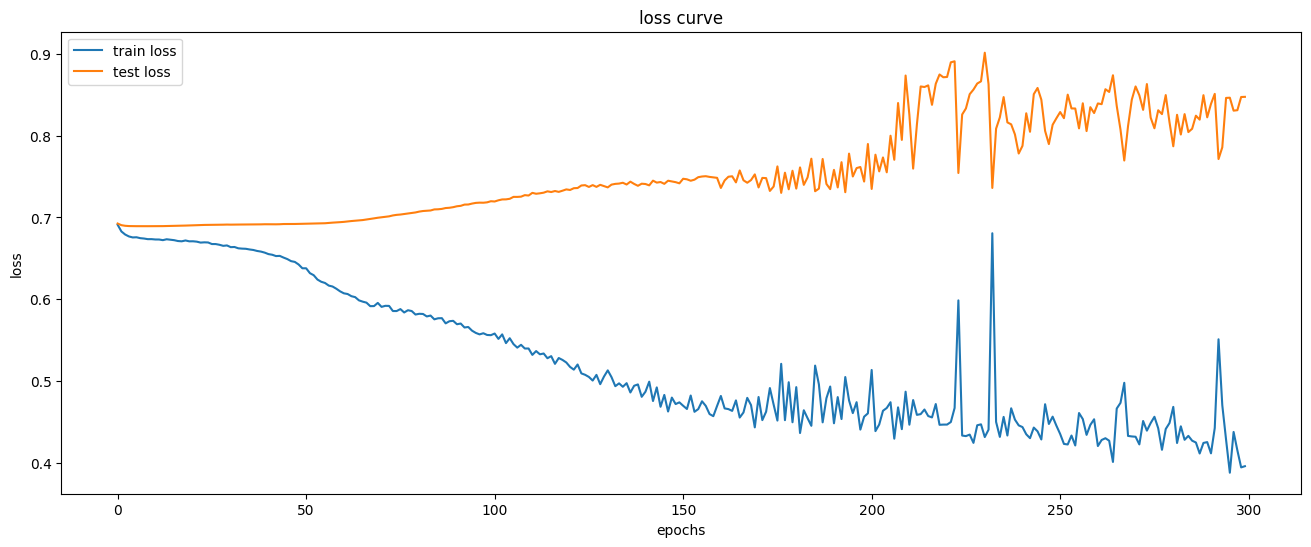

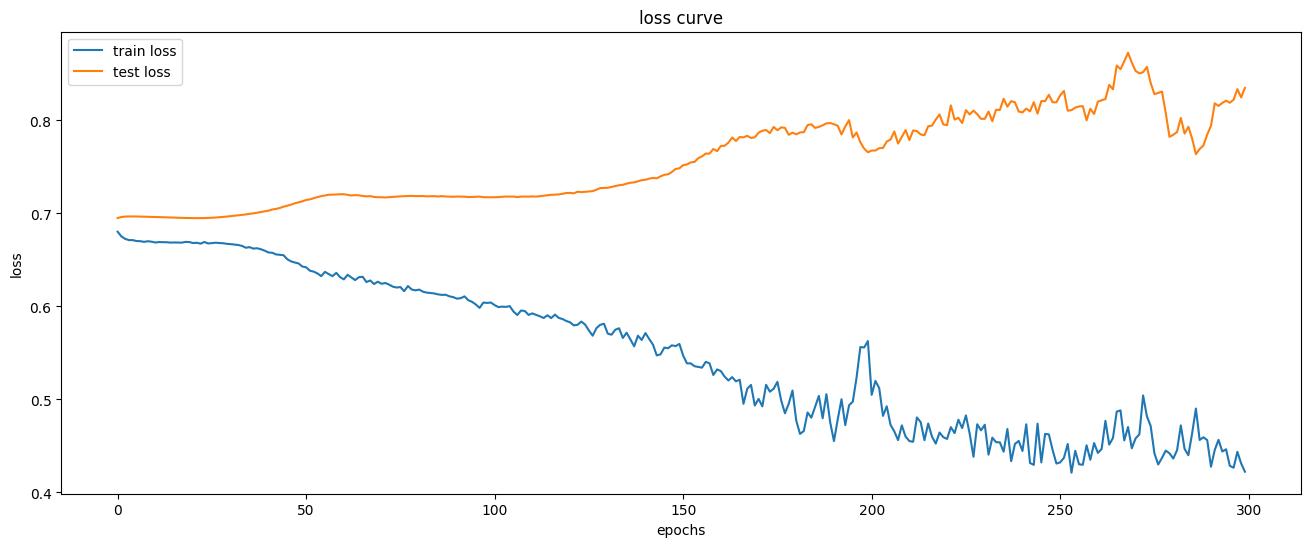

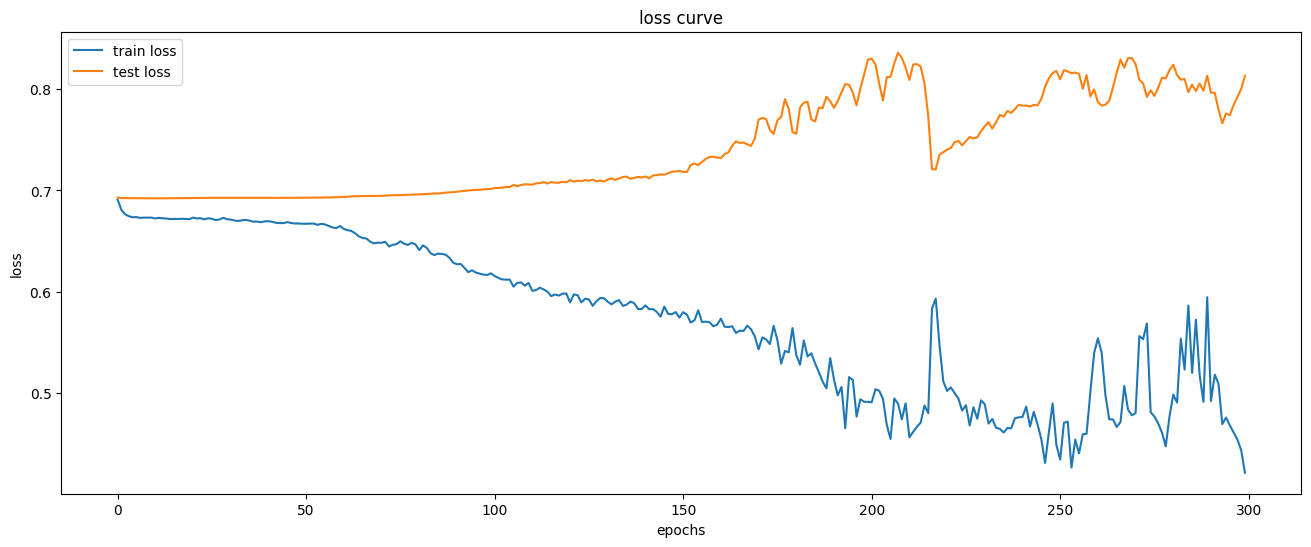

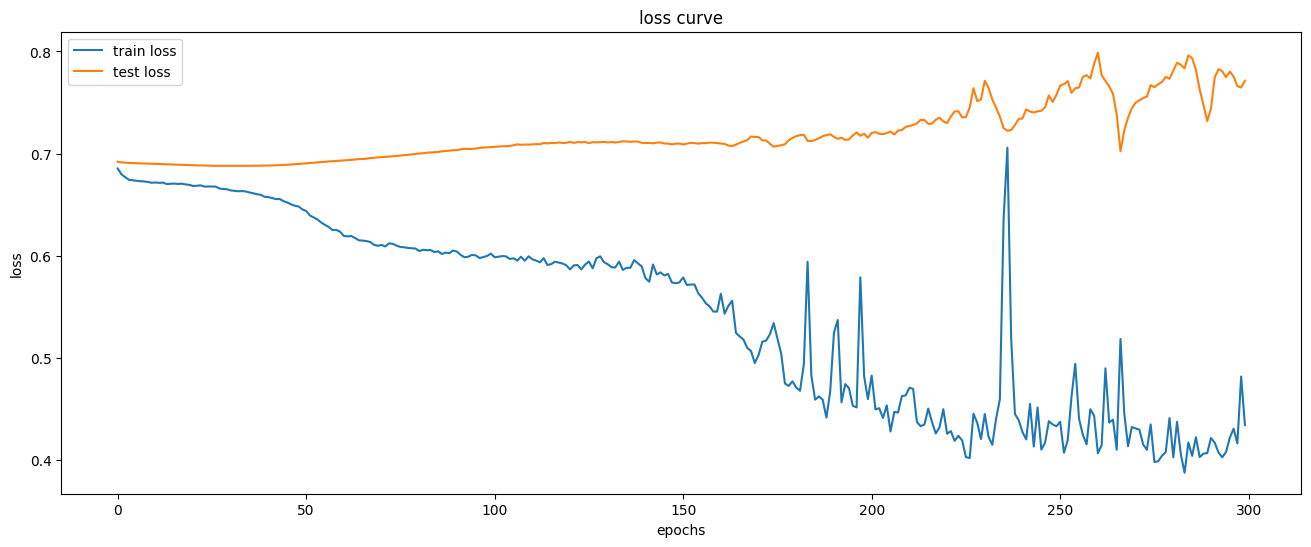

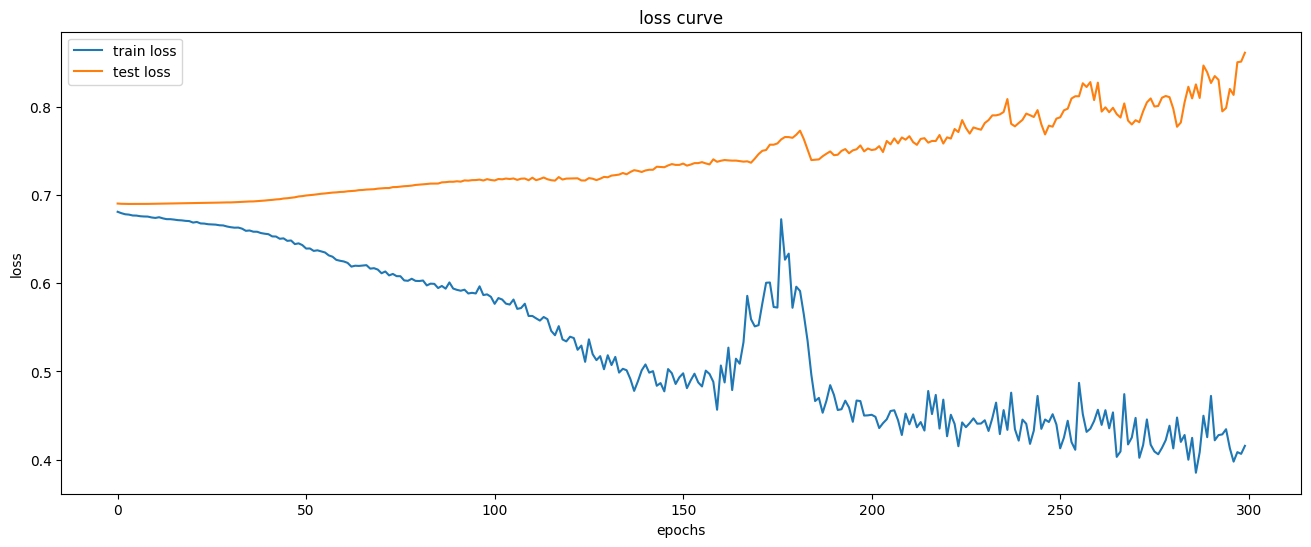

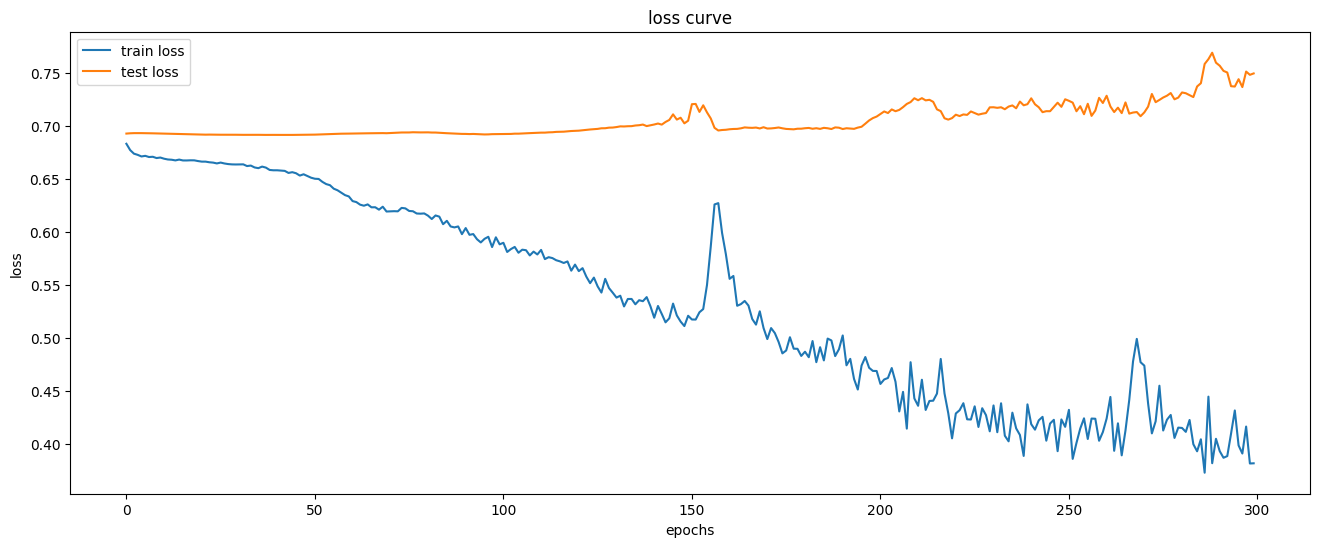

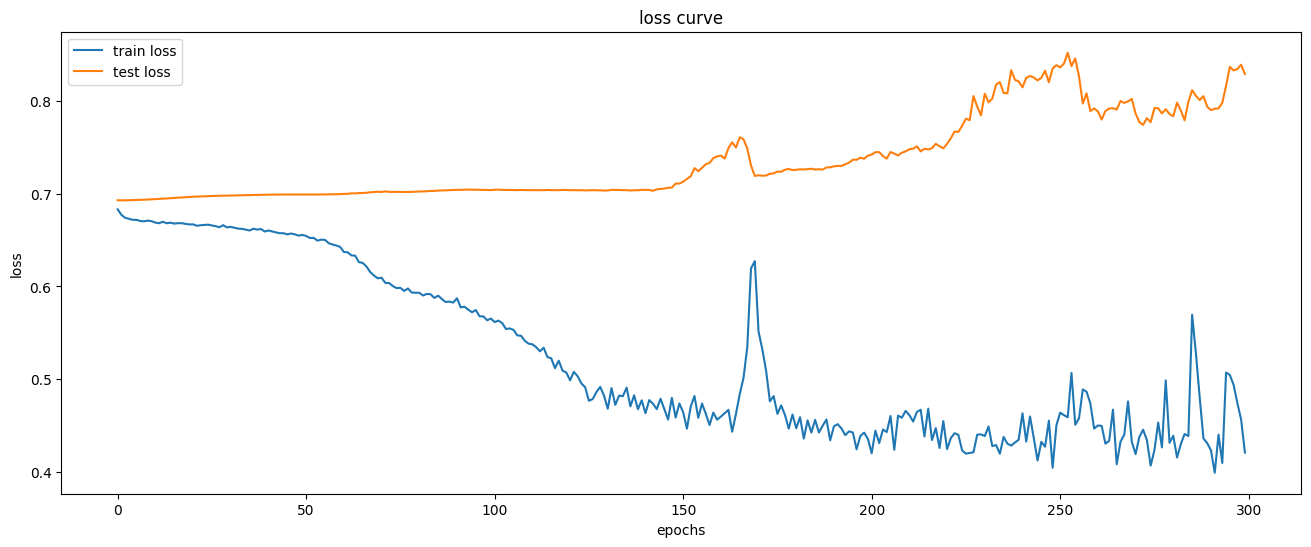

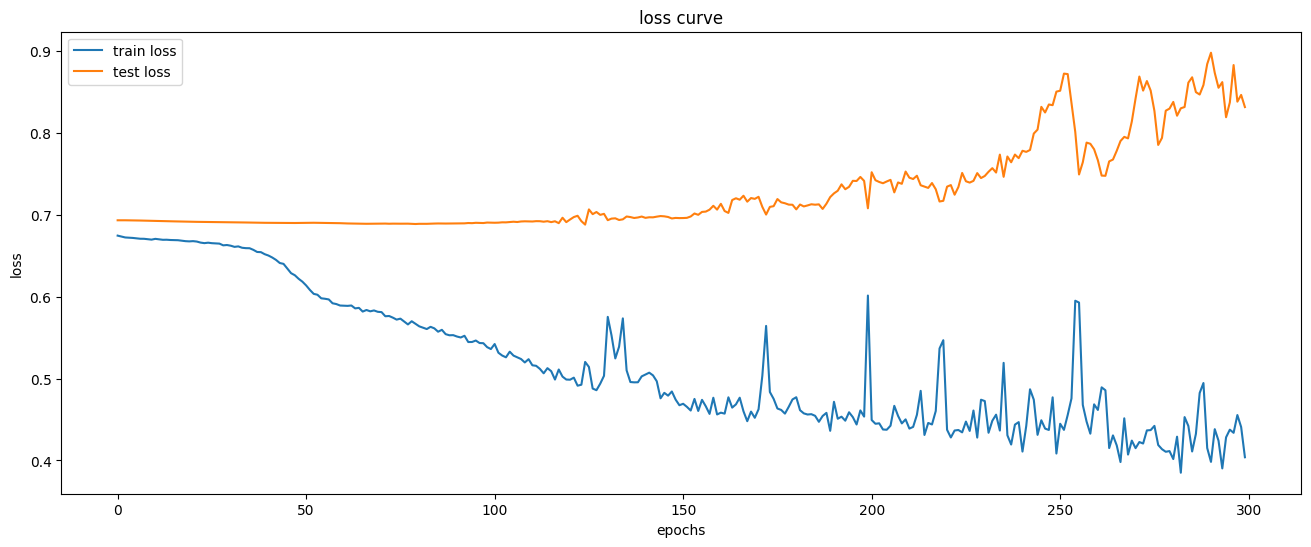

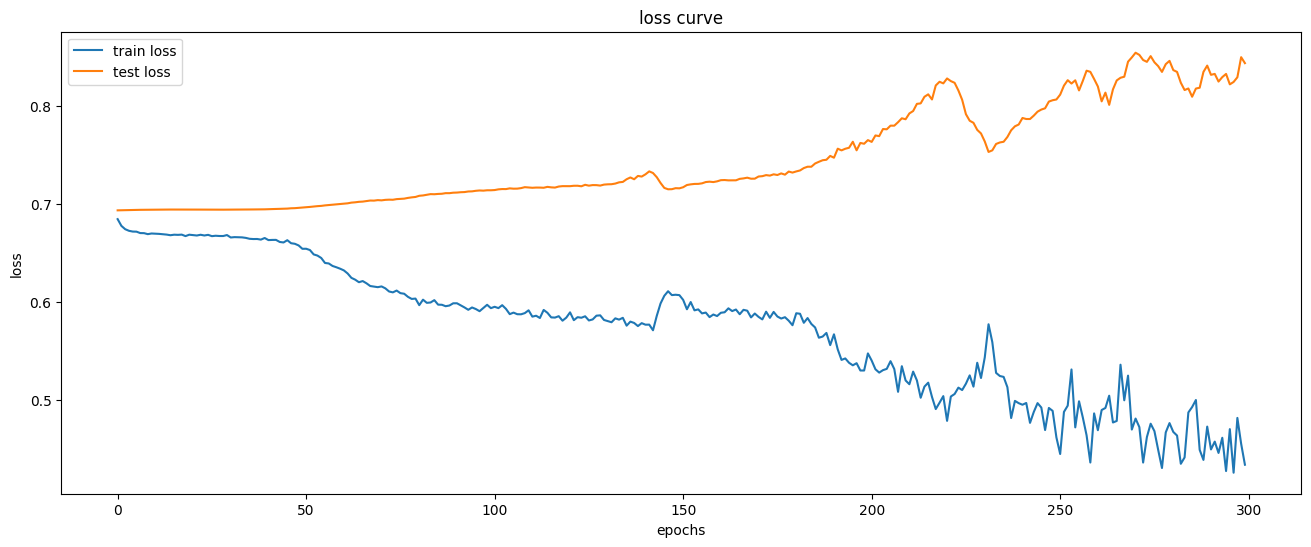

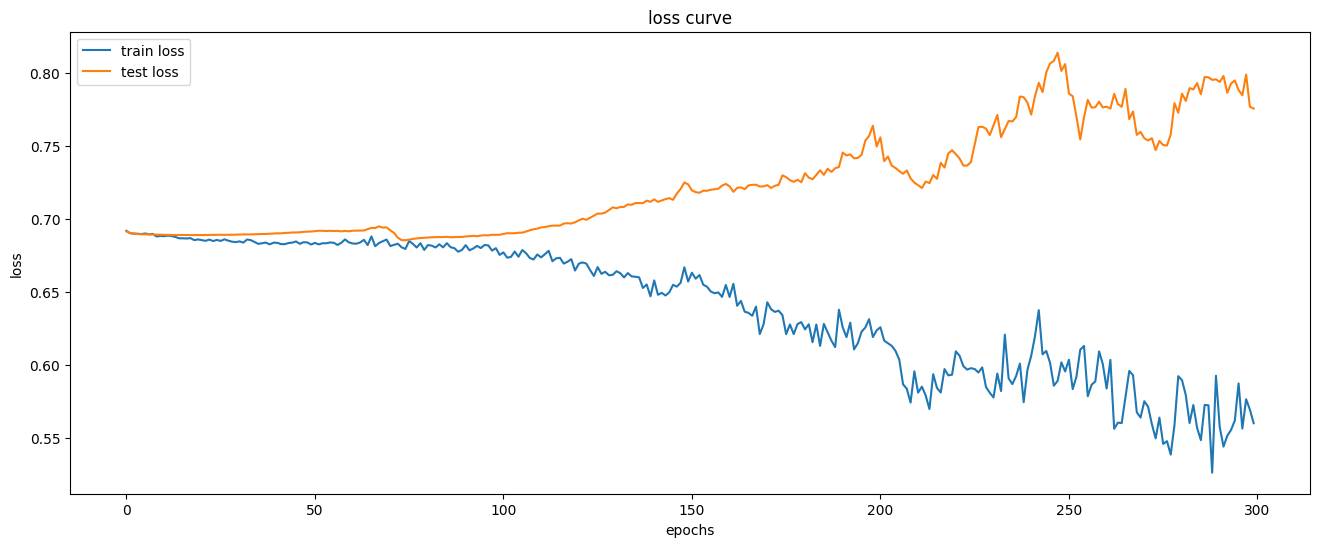

In [25]:
for i in range(len(train_loss_history)):
    plt.figure(figsize=(16,6))
    plt.plot(train_loss_history[i])
    plt.plot(test_loss_history[i])
    plt.legend(['train loss', 'test loss'], loc='upper left')
    plt.title("loss curve")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

In [26]:
dates = aapl.index[sequence_length:-validationLength]

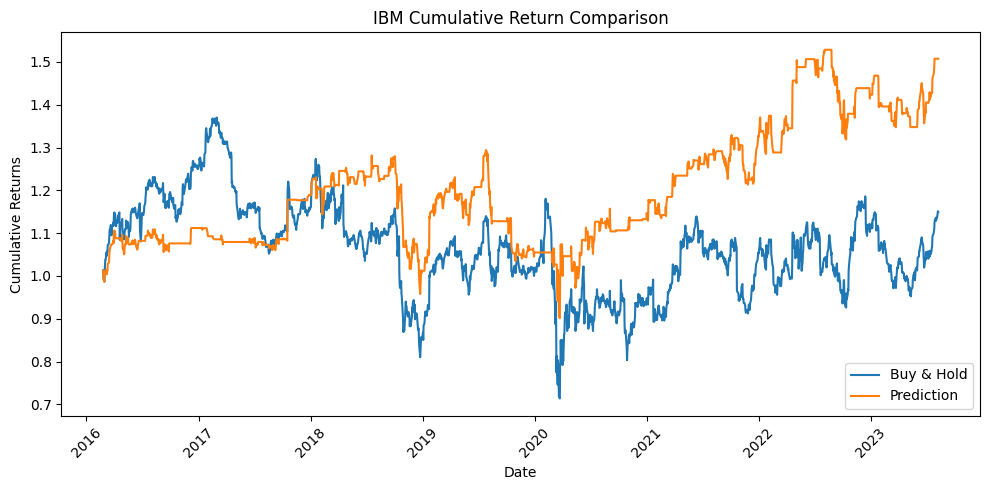

In [27]:

def cum_return(probabilities, actuals, pct_change, lc,dates, ticker):
    pct_change = np.array(pct_change)
    predictions_array = (np.array(probabilities) > 0.5).astype(int)
    
    # Calculate cumulative returns
    buy_and_hold = (pct_change + 1).cumprod()
    prediction = (predictions_array * pct_change + 1).cumprod()
    lc = (lc > 0).astype(int)
    lc = (lc * pct_change + 1).cumprod()
    # Create the plot
    plt.figure(figsize=(10, 5))  # Adjust the size as needed
    plt.plot(dates, buy_and_hold, label='Buy & Hold')
    plt.plot(dates, prediction, label='Prediction')
    #plt.plot(dates, lc, label='lc')
    
    # Setting the x-axis as date
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.xlabel('Date')
    
    # Labels and legend
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='lower right')
    
    # Title
    plt.title(f"{ticker} Cumulative Return Comparison")
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Example usage of the function, assuming that 'aapl.index[20:-100]' is the desired date range
# Adjust 'probabilities', 'actuals', and 'aapl['pct_change']' to be aligned and have the same length

# Slice the dates
#dates = aapl.index[20:-100]

# Call the function with the aligned data
cum_return(probabilities, actuals, aapl['pct_change'][sequence_length:-validationLength], aapl['prediction'][sequence_length:-validationLength], dates, ticker)

In [28]:
aapl.columns

Index(['Volume', 'SP500_diff', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_mfi', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw',
       ...
       'trend_ichimoku_conv_fdiff', 'trend_ichimoku_base_fdiff',
       'trend_ichimoku_a_fdiff', 'trend_ichimoku_b_fdiff',
       'trend_visual_ichimoku_a_fdiff', 'trend_visual_ichimoku_b_fdiff',
       'momentum_kama_fdiff', 'others_cr_fdiff', 'Supertrend7_3_fdiff',
       'Supertrend10_3_fdiff'],
      dtype='object', length=109)

In [29]:
evaluation(predictions,probabilities,actuals)

Accuracy: 0.4941
Precision: 0.5196
Recall: 0.4588
F1 Score: 0.4873
AUC Score: 0.5016
Confusion Matrix:
[[476 417]
 [532 451]]


In [30]:
downside_deviation_list = np.array(downside_deviation_list)
np.std(downside_deviation_list)

0.002668623697513236

In [31]:
downside_deviation_list

array([0.00421053, 0.0021118 , 0.00493211, 0.00872658, 0.00879886,
       0.01176854, 0.00438916, 0.00531488, 0.00663818, 0.00545971])